In [13]:
import pandas as pd

df = pd.read_csv('/Users/ki.markov/downloads/hw sofia/cian_processed_data-2.csv')

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def preprocess_data(df):
    data = df.copy()
    
    # Обработка пропущенных значений
    data = data.fillna(data.median(numeric_only=True))
    
    # Удаление выбросов 
    Q1 = data['price'].quantile(0.25)
    Q3 = data['price'].quantile(0.75)
    IQR = Q3 - Q1
    data = data[~((data['price'] < (Q1 - 1.5 * IQR)) | (data['price'] > (Q3 + 1.5 * IQR)))]
    
    return data

df_processed = preprocess_data(df)

X = df_processed.drop(columns = ['price', 'price_log'], axis=1)  
y = df_processed['price']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

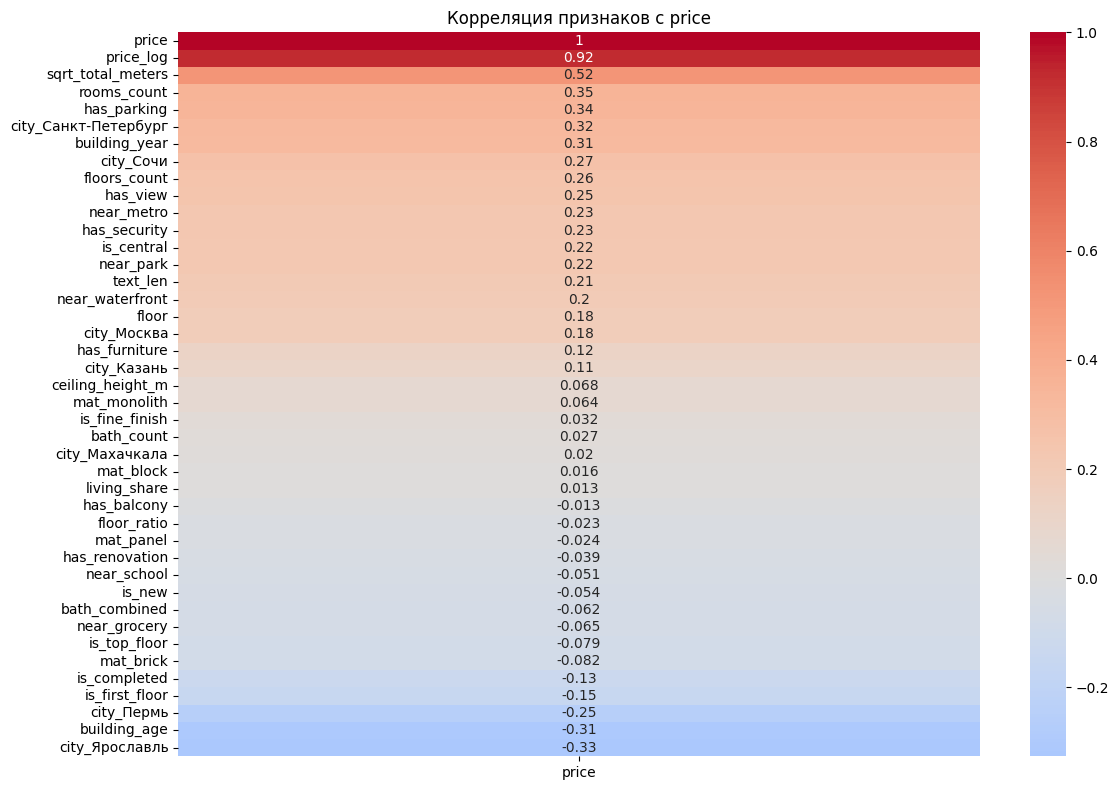

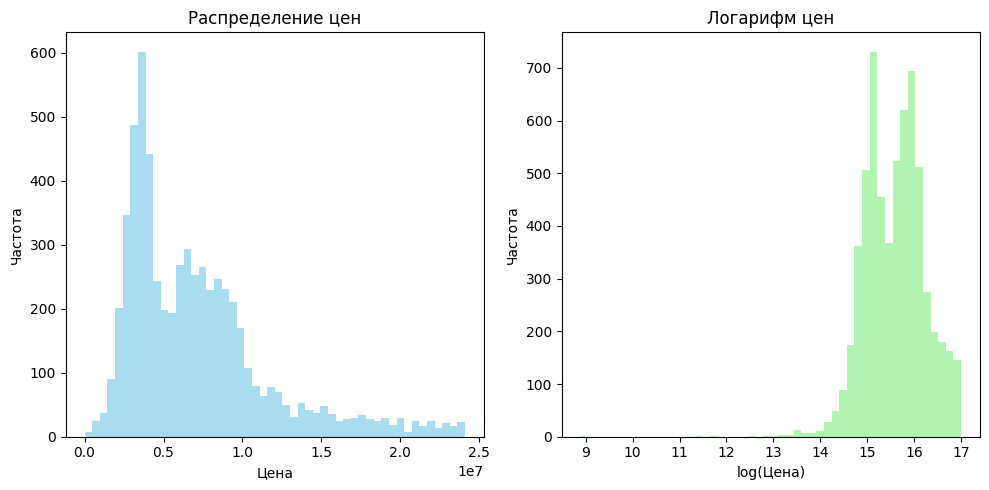

Топ коррелирующих признаков с ценой:
price                   1.000000
price_log               0.920867
sqrt_total_meters       0.520711
rooms_count             0.354119
has_parking             0.343910
city_Ярославль          0.326067
city_Санкт-Петербург    0.322689
building_year           0.313299
building_age            0.312502
city_Сочи               0.265499
Name: price, dtype: float64


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_data(df, target_col='price'):
    # Корреляционная матрица
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix[target_col].sort_values(ascending=False).to_frame(), 
                annot=True, cmap='coolwarm', center=0)
    plt.title(f'Корреляция признаков с {target_col}')
    plt.tight_layout()
    plt.show()
    
    # Распределение целевой переменной
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(df[target_col], bins=50, alpha=0.7, color='skyblue')
    plt.title('Распределение цен')
    plt.xlabel('Цена')
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    plt.hist(np.log1p(df[target_col]), bins=50, alpha=0.7, color='lightgreen')
    plt.title('Логарифм цен')
    plt.xlabel('log(Цена)')
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()
    
    # Топ коррелирующих признаков
    corr_with_target = correlation_matrix[target_col].abs().sort_values(ascending=False)
    print("Топ коррелирующих признаков с ценой:")
    print(corr_with_target.head(10))

# Анализируем данные
analyze_data(df_processed)

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Создаем словарь моделей
classic_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'SVR': SVR(kernel='rbf', C=1.0),
    'K-Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Обучение и оценка классических моделей
for name, model in classic_models.items():
    if name in ['SVR', 'K-Neighbors']:
        # Для этих моделей используем масштабированные данные
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MAE = {mae:.2f}, R² = {r2:.4f}")

Random Forest: MAE = 1269410.19, R² = 0.8007
Linear Regression: MAE = 1660130.43, R² = 0.7361
Ridge Regression: MAE = 1659429.53, R² = 0.7363
Lasso Regression: MAE = 1663191.21, R² = 0.7349


/Users/ki.markov/miniconda3/envs/sofia_hw/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.028e+16, tolerance: 8.298e+12
  model = cd_fast.enet_coordinate_descent(


SVR: MAE = 3394704.13, R² = -0.0449
K-Neighbors: MAE = 1883802.57, R² = 0.6105


In [17]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# CatBoost
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=False
)

# Обучение и оценка
models = {
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'CatBoost': cat_model
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MAE = {mae:.2f}, R² = {r2:.4f}")

XGBoost: MAE = 1217654.54, R² = 0.8141
LightGBM: MAE = 1254689.99, R² = 0.8135
CatBoost: MAE = 1215083.51, R² = 0.8300


In [18]:
from sklearn.ensemble import RandomForestRegressor
import optuna
from optuna.samplers import TPESampler

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return np.sqrt(mean_squared_error(y_valid, preds))

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=30)
print("Random Forest — лучшее RMSE:", study_rf.best_value)
print("Параметры:", study_rf.best_params)

/Users/ki.markov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-26 20:49:24,000] A new study created in memory with name: no-name-bbf51c0c-5770-497f-baae-6b43b8d9e170
[I 2025-10-26 20:49:24,432] Trial 0 finished with value: 2448035.8232091875 and parameters: {'n_estimators': 171, 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 2448035.8232091875.
[I 2025-10-26 20:49:24,749] Trial 1 finished with value: 2360497.761738121 and parameters: {'n_estimators': 102, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 2360497.761738121.
[I 2025-10-26 20:49:25,430] Trial 2 finished with value: 2168599.439585043 and param

Random Forest — лучшее RMSE: 1958899.0045812107
Параметры: {'n_estimators': 104, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}


In [19]:
from sklearn.linear_model import Ridge

def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 100, log=True)
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return np.sqrt(mean_squared_error(y_valid, preds))

study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=30)
print("Ridge — лучшее RMSE:", study_ridge.best_value)
print("Параметры:", study_ridge.best_params)

[I 2025-10-26 20:50:00,417] A new study created in memory with name: no-name-2d5133cf-199c-4bae-b43f-5ea683348a88
[I 2025-10-26 20:50:00,425] Trial 0 finished with value: 2295054.7522895145 and parameters: {'alpha': 6.376670546112159}. Best is trial 0 with value: 2295054.7522895145.
[I 2025-10-26 20:50:00,429] Trial 1 finished with value: 2298288.370656493 and parameters: {'alpha': 0.08168320987999488}. Best is trial 0 with value: 2295054.7522895145.
[I 2025-10-26 20:50:00,432] Trial 2 finished with value: 2298380.878423005 and parameters: {'alpha': 0.018153493656911927}. Best is trial 0 with value: 2295054.7522895145.
[I 2025-10-26 20:50:00,436] Trial 3 finished with value: 2298407.509237588 and parameters: {'alpha': 7.996672562718002e-05}. Best is trial 0 with value: 2295054.7522895145.
[I 2025-10-26 20:50:00,439] Trial 4 finished with value: 2298030.594793784 and parameters: {'alpha': 0.2652161594592607}. Best is trial 0 with value: 2295054.7522895145.
[I 2025-10-26 20:50:00,445] Tr

Ridge — лучшее RMSE: 2295002.19084339
Параметры: {'alpha': 5.434007498493522}


In [20]:
from sklearn.linear_model import Lasso

def objective_lasso(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 10, log=True)
    model = Lasso(alpha=alpha, max_iter=5000, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return np.sqrt(mean_squared_error(y_valid, preds))

study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=30)
print("Lasso — лучшее RMSE:", study_lasso.best_value)
print("Параметры:", study_lasso.best_params)

[I 2025-10-26 20:50:00,546] A new study created in memory with name: no-name-0c04ce60-b518-4701-88a3-438e130553c1
/Users/ki.markov/miniconda3/envs/sofia_hw/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.027e+16, tolerance: 8.298e+12
  model = cd_fast.enet_coordinate_descent(
[I 2025-10-26 20:50:01,043] Trial 0 finished with value: 2297356.958982788 and parameters: {'alpha': 0.004596347457243424}. Best is trial 0 with value: 2297356.958982788.
/Users/ki.markov/miniconda3/envs/sofia_hw/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.027e+16, tolerance: 8.298e+1

Lasso — лучшее RMSE: 2297341.9342642897
Параметры: {'alpha': 9.254107550125466}


In [21]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# SVR чувствителен к масштабу — нужно нормализовать
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

def objective_svr(trial):
    C = trial.suggest_float('C', 0.1, 100, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    gamma = trial.suggest_float('gamma', 1e-4, 1, log=True)
    
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
        model = SVR(C=C, kernel=kernel, gamma=gamma, degree=degree)
    else:
        model = SVR(C=C, kernel=kernel, gamma=gamma)
    
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_valid_scaled)
    return np.sqrt(mean_squared_error(y_valid, preds))

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=30)
print("SVR — лучшее RMSE:", study_svr.best_value)
print("Параметры:", study_svr.best_params)

[I 2025-10-26 20:50:15,708] A new study created in memory with name: no-name-42f5e9ac-e78b-4222-8ae4-80a7b0e7c7a8
[I 2025-10-26 20:50:16,363] Trial 0 finished with value: 4572954.520765583 and parameters: {'C': 0.48231025849047215, 'kernel': 'rbf', 'gamma': 0.02541070162952062}. Best is trial 0 with value: 4572954.520765583.
[I 2025-10-26 20:50:16,811] Trial 1 finished with value: 4355693.760368154 and parameters: {'C': 0.17849065687537988, 'kernel': 'poly', 'gamma': 0.9083877844468697, 'degree': 3}. Best is trial 1 with value: 4355693.760368154.
[I 2025-10-26 20:50:17,253] Trial 2 finished with value: 4572973.013356395 and parameters: {'C': 58.26105637027632, 'kernel': 'poly', 'gamma': 0.0024322739911236233, 'degree': 5}. Best is trial 1 with value: 4355693.760368154.
[I 2025-10-26 20:50:17,967] Trial 3 finished with value: 4571509.322901 and parameters: {'C': 3.394892231193395, 'kernel': 'sigmoid', 'gamma': 0.3520189686114254}. Best is trial 1 with value: 4355693.760368154.
[I 2025-1

SVR — лучшее RMSE: 2910776.918746772
Параметры: {'C': 10.306547459531222, 'kernel': 'poly', 'gamma': 0.30382185413681745, 'degree': 5}


In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# KNN тоже требует масштабирования
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 2, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    
    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric
    )
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_valid_scaled)
    return np.sqrt(mean_squared_error(y_valid, preds))

study_knn = optuna.create_study(direction='minimize')
study_knn.optimize(objective_knn, n_trials=30)
print("KNN — лучшее RMSE:", study_knn.best_value)
print("Параметры:", study_knn.best_params)

[I 2025-10-26 20:50:35,980] A new study created in memory with name: no-name-8739dfad-d2c8-4609-b24f-69e99a1b8ef4
[I 2025-10-26 20:50:35,997] Trial 0 finished with value: 2705902.4265400735 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 2705902.4265400735.
[I 2025-10-26 20:50:36,008] Trial 1 finished with value: 2840907.968053064 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 2705902.4265400735.
[I 2025-10-26 20:50:36,036] Trial 2 finished with value: 2864974.286409751 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 2705902.4265400735.
[I 2025-10-26 20:50:36,090] Trial 3 finished with value: 2728389.6228484693 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 2705902.4265400735.
[I 2025-10-26 20:50:36,111] Trial 4 finished with value: 266700

KNN — лучшее RMSE: 2583825.9403121886
Параметры: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'minkowski'}


In [23]:
import lightgbm as lgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMRegressor

def objective_sklearn(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 7),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42
    }

    model = LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=False
    )
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return rmse

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_sklearn, n_trials=30)

print(f"Лучшее значение RMSE: {study_lgb.best_value}")
print(f"Лучшие параметры: {study_lgb.best_params}")


[I 2025-10-26 20:50:36,528] A new study created in memory with name: no-name-f78c5bc4-09b6-46e5-9dd7-33f9a85d4cea
/Users/ki.markov/miniconda3/envs/sofia_hw/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/ki.markov/miniconda3/envs/sofia_hw/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2025-10-26 20:50:37,276] Trial 0 finished with value: 3058412.9578645905 and parameters: {'n_estimators': 474, 'learning_ra

Лучшее значение RMSE: 1854073.8662574384
Лучшие параметры: {'n_estimators': 500, 'learning_rate': 0.06217938863783786, 'max_depth': 6, 'reg_alpha': 0.0010493755435569611, 'reg_lambda': 0.5581363230115588}


In [24]:
lgb_model = lgb.LGBMRegressor(
    **study_lgb.best_params   
)

In [25]:
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"lgb_model: MAE = {mae:.2f}, R² = {r2:.4f}")

lgb_model: MAE = 1251307.57, R² = 0.8175


In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 10.0, log=True),
        'random_state': 42,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }

    # Создаём модель без fit-аргументов
    model = xgb.XGBRegressor(**params)

    # Обучение с eval_set и early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],      
        verbose=False
    )

    # Оценка
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return rmse

# 3. Запуск Optuna
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective, n_trials=30)

print(f"Лучшее значение RMSE: {study_xgb.best_value:.4f}")
print(f"Лучшие параметры: {study_xgb.best_params}")

[I 2025-10-26 20:50:57,407] A new study created in memory with name: no-name-afa5f8db-2819-40fd-8040-4c837793c276
[I 2025-10-26 20:50:57,789] Trial 0 finished with value: 3143059.164765743 and parameters: {'n_estimators': 369, 'learning_rate': 0.0034436491841380854, 'max_depth': 3, 'subsample': 0.714843555496701, 'colsample_bytree': 0.821706264255653, 'reg_alpha': 0.00047861929814635646, 'reg_lambda': 9.992679477017248, 'min_child_weight': 5, 'gamma': 1.3757979814431734e-07}. Best is trial 0 with value: 3143059.164765743.
[I 2025-10-26 20:50:58,156] Trial 1 finished with value: 2401946.8267811723 and parameters: {'n_estimators': 209, 'learning_rate': 0.007448072625089087, 'max_depth': 7, 'subsample': 0.5613317830433082, 'colsample_bytree': 0.6300614769082575, 'reg_alpha': 4.684136647371624, 'reg_lambda': 0.2465934075049283, 'min_child_weight': 7, 'gamma': 1.017764046571124e-06}. Best is trial 1 with value: 2401946.8267811723.
[I 2025-10-26 20:50:58,725] Trial 2 finished with value: 186

Лучшее значение RMSE: 1812598.5198
Лучшие параметры: {'n_estimators': 496, 'learning_rate': 0.03485206263034879, 'max_depth': 7, 'subsample': 0.8698290813048418, 'colsample_bytree': 0.5357626476518736, 'reg_alpha': 6.647484707651035e-05, 'reg_lambda': 0.005305983765440085, 'min_child_weight': 3, 'gamma': 1.8996169070382086e-06}


In [27]:
import catboost as cb

def objective(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'depth': trial.suggest_int('depth', 1, 7),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'random_state': 42,
        'verbose': False,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE'
    }

    # Особые параметры для политик роста дерева
    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 2, 64)

    # Создание и обучение модели
    model = cb.CatBoostRegressor(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=False
    )

    # Оценка
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return rmse  # Минимизируем RMSE

# 3. Запуск Optuna
study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(objective, n_trials=30)

# 4. Вывод результатов
print(f"Лучшее значение RMSE: {study_cb.best_value:.4f}")
print(f"Лучшие параметры: {study_cb.best_params}")

[I 2025-10-26 20:51:13,616] A new study created in memory with name: no-name-d5e7ad3e-71bc-4d71-a897-ce1b631646c0
[I 2025-10-26 20:51:14,160] Trial 0 finished with value: 1909519.8457888772 and parameters: {'learning_rate': 0.02716177174687447, 'depth': 4, 'l2_leaf_reg': 2.5381042195691155, 'subsample': 0.808305742943231, 'colsample_bylevel': 0.938275363544699, 'min_data_in_leaf': 39, 'random_strength': 0.00032697029312171526, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 1909519.8457888772.
[I 2025-10-26 20:51:14,637] Trial 1 finished with value: 1869637.9614996316 and parameters: {'learning_rate': 0.09515687601582856, 'depth': 5, 'l2_leaf_reg': 0.09077225399120695, 'subsample': 0.5874044617572131, 'colsample_bylevel': 0.9330362781980432, 'min_data_in_leaf': 26, 'random_strength': 0.0011517098096933726, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 1869637.9614996316.
[I 2025-10-26 20:51:14,999] Trial 2 finished with value: 1852251.7505746807 and parameters: 

Лучшее значение RMSE: 1793567.6840
Лучшие параметры: {'learning_rate': 0.05967193042958555, 'depth': 7, 'l2_leaf_reg': 0.006774154984540293, 'subsample': 0.5060358880832687, 'colsample_bylevel': 0.5585839851800783, 'min_data_in_leaf': 7, 'random_strength': 0.0070050665014360506, 'grow_policy': 'Depthwise'}


In [28]:
# Обучение и оценка
models = {
    'XGBoost': xgb.XGBRegressor(**study_xgb.best_params),
    'LightGBM': lgb.LGBMRegressor(**study_lgb.best_params),
    'CatBoost': CatBoostRegressor(**study_cb.best_params),
    'Random Forest': RandomForestRegressor(**study_rf.best_params),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(**study_ridge.best_params),
    'Lasso Regression': Lasso(**study_lasso.best_params),
    'K-Neighbors': KNeighborsRegressor(**study_knn.best_params)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MAE = {mae:.2f}, R² = {r2:.4f}")

XGBoost: MAE = 1211604.27, R² = 0.8211
LightGBM: MAE = 1251307.57, R² = 0.8175
0:	learn: 4400279.8162684	total: 2.81ms	remaining: 2.81s
1:	learn: 4215479.4580467	total: 5.64ms	remaining: 2.81s
2:	learn: 4043131.8641155	total: 8.49ms	remaining: 2.82s
3:	learn: 3878119.3422108	total: 11.6ms	remaining: 2.9s
4:	learn: 3725429.5296895	total: 14.5ms	remaining: 2.88s
5:	learn: 3585620.2452070	total: 17.2ms	remaining: 2.85s
6:	learn: 3457810.3862430	total: 20.1ms	remaining: 2.85s
7:	learn: 3335623.1639064	total: 23.3ms	remaining: 2.88s
8:	learn: 3215321.0943491	total: 26.1ms	remaining: 2.88s
9:	learn: 3106788.3397678	total: 28.9ms	remaining: 2.86s
10:	learn: 3006282.3608652	total: 31.5ms	remaining: 2.83s
11:	learn: 2916053.5670725	total: 34ms	remaining: 2.8s
12:	learn: 2823408.1245859	total: 36.5ms	remaining: 2.77s
13:	learn: 2736569.8400201	total: 39.6ms	remaining: 2.79s
14:	learn: 2654122.3233238	total: 42.9ms	remaining: 2.81s
15:	learn: 2579722.4526038	total: 45.8ms	remaining: 2.81s
16:	lea

/Users/ki.markov/miniconda3/envs/sofia_hw/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.027e+16, tolerance: 8.298e+12
  model = cd_fast.enet_coordinate_descent(


In [36]:
catboost_model = CatBoostRegressor(**study_cb.best_params)

catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

0:	learn: 4400279.8162684	total: 3.84ms	remaining: 3.84s
1:	learn: 4215479.4580467	total: 7.62ms	remaining: 3.8s
2:	learn: 4043131.8641155	total: 12.5ms	remaining: 4.17s
3:	learn: 3878119.3422108	total: 16ms	remaining: 3.98s
4:	learn: 3725429.5296895	total: 19.5ms	remaining: 3.88s
5:	learn: 3585620.2452070	total: 23ms	remaining: 3.81s
6:	learn: 3457810.3862430	total: 29.2ms	remaining: 4.14s
7:	learn: 3335623.1639064	total: 32.9ms	remaining: 4.08s
8:	learn: 3215321.0943491	total: 36.1ms	remaining: 3.97s
9:	learn: 3106788.3397678	total: 39.1ms	remaining: 3.87s
10:	learn: 3006282.3608652	total: 42.2ms	remaining: 3.79s
11:	learn: 2916053.5670725	total: 45ms	remaining: 3.71s
12:	learn: 2823408.1245859	total: 47.6ms	remaining: 3.61s
13:	learn: 2736569.8400201	total: 50.2ms	remaining: 3.54s
14:	learn: 2654122.3233238	total: 53ms	remaining: 3.48s
15:	learn: 2579722.4526038	total: 55.5ms	remaining: 3.42s
16:	learn: 2514765.6429145	total: 58.4ms	remaining: 3.37s
17:	learn: 2445652.4059056	total:

In [ ]:
import shap

explainer = shap.TreeExplainer(catboost_model)

# Вычисляем SHAP values для валидационной выборки
shap_values = explainer.shap_values(X_valid)

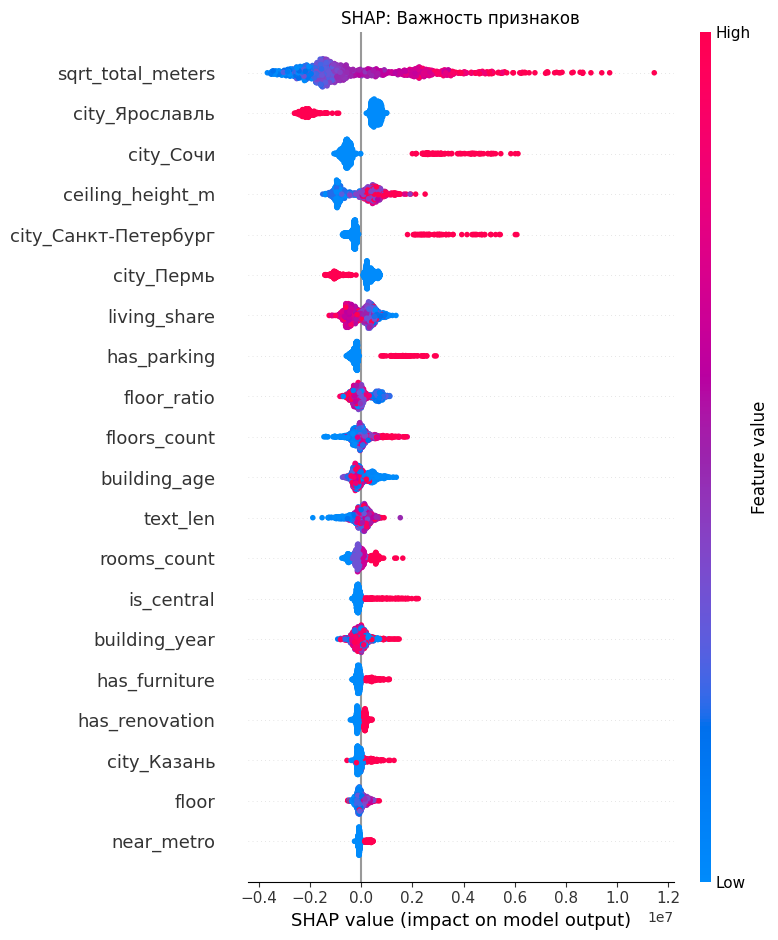

In [38]:
shap.summary_plot(shap_values, X_valid, feature_names=X.columns, show=False)
plt.title("SHAP: Важность признаков")
plt.tight_layout()
plt.show()

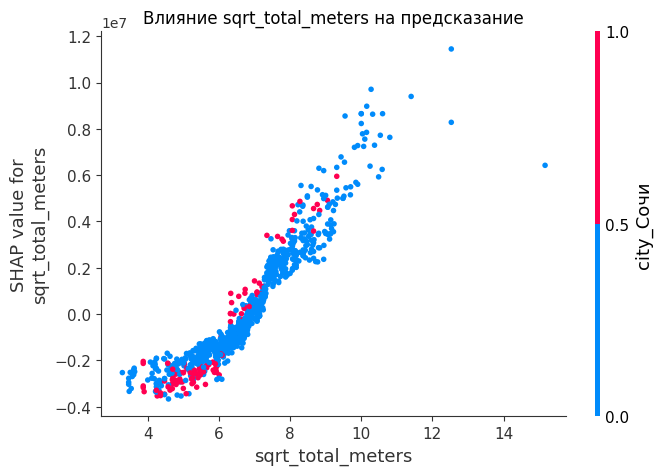

In [40]:
# Пример: влияние среднего возраста домов (MedInc)
shap.dependence_plot("sqrt_total_meters", shap_values, X_valid, show=False)
plt.title("Влияние sqrt_total_meters на предсказание")
plt.show()

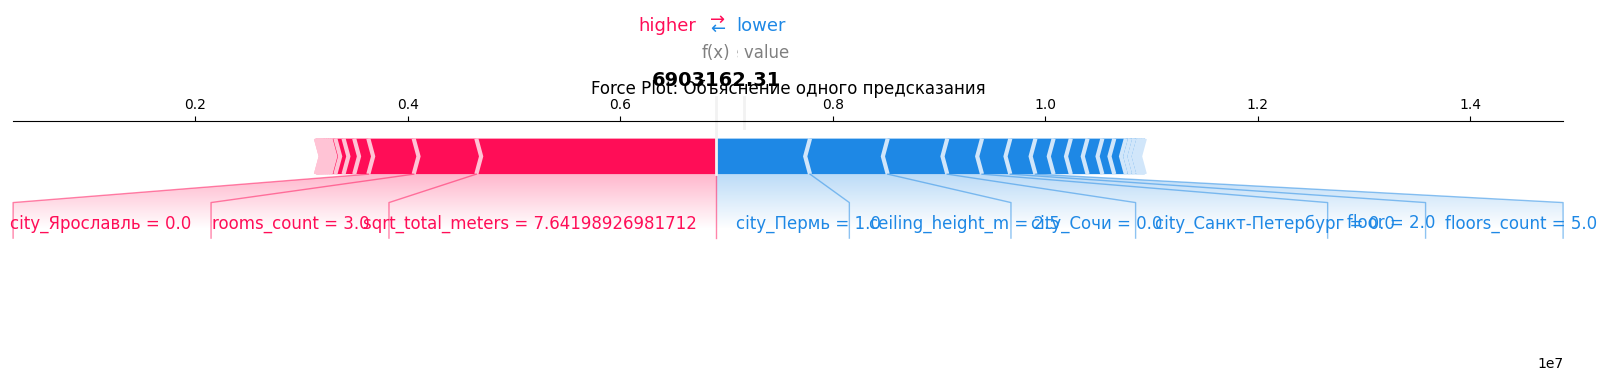

In [43]:
# Первый объект из валидации
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_valid.iloc[0], matplotlib=True, show=False)
plt.title("Force Plot: Объяснение одного предсказания", pad=20)
plt.show()

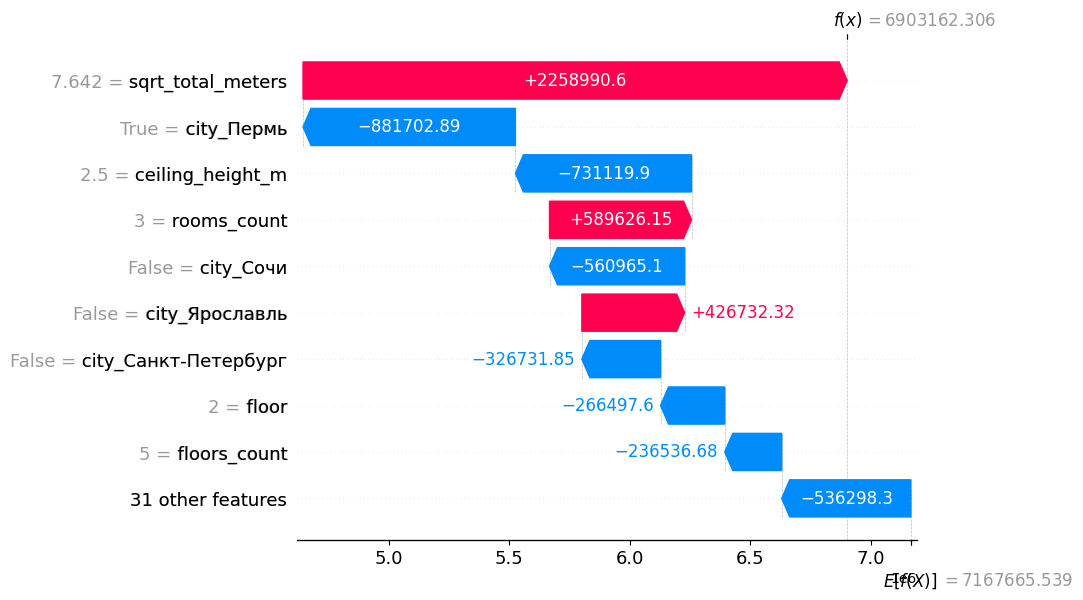

In [44]:
# Для первого объекта
shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=X_valid.iloc[0], 
                                     feature_names=X_valid.columns.tolist()))
plt.show()

In [41]:
# Средний абсолютный SHAP value — важность признака
shap_importance = pd.DataFrame({
    'feature': X_valid.columns,
    'shap_importance': np.mean(np.abs(shap_values), axis=0)
}).sort_values('shap_importance', ascending=False)

print(shap_importance)

                 feature  shap_importance
39     sqrt_total_meters     1.998241e+06
38        city_Ярославль     9.515117e+05
37             city_Сочи     9.085864e+05
8       ceiling_height_m     6.524940e+05
36  city_Санкт-Петербург     5.340151e+05
35            city_Пермь     5.115767e+05
7           living_share     4.152260e+05
20           has_parking     3.585328e+05
11           floor_ratio     3.079923e+05
2           floors_count     2.758058e+05
5           building_age     2.673372e+05
3               text_len     2.542346e+05
0            rooms_count     2.432224e+05
12            is_central     2.181804e+05
4          building_year     2.151289e+05
22         has_furniture     1.758376e+05
13        has_renovation     1.494302e+05
32           city_Казань     1.398785e+05
1                  floor     1.366473e+05
29            near_metro     1.182028e+05
33        city_Махачкала     1.082944e+05
27             near_park     1.063568e+05
34           city_Москва     1.002

In [42]:
print(f"Базовое значение (среднее предсказание): {explainer.expected_value:.2f}")
print(f"Фактическое предсказание для первого объекта: {model.predict(X_valid.iloc[[0]])[0]:.2f}")

Базовое значение (среднее предсказание): 7167665.54
Фактическое предсказание для первого объекта: 5700686.66
